In [3]:
install.packages("corrplot")
install.packages("plot3D")
install.packages("fastICA")
install.packages("fields")
install.packages("caretEnsemble")
install.packages("gbm")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependency ‘misc3d’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘dotCall64’, ‘spam’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependency ‘pbapply’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [44]:
install.packages("Cubist")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [4]:
library(corrplot)
library(reshape2)
library(gridExtra)
library(ggplot2)
library(plot3D)
library(dplyr)
library(fastICA)
library(broom)
library(fields)
library(caret)
library(caretEnsemble)

# Function to read the data
read_data <- function(filename)
{
  dset <- read.table(filename)
  colnames(dset)[1:5] <- c("unit_no", "t", "op1", "op2", "op3")
  colnames(dset)[6:26] <- sprintf("s%s", 1:21)
  dset$unit_no <- as.factor(dset$unit_no)
  return(dset)
}

train <- read_data(url("https://raw.githubusercontent.com/gomathyshankar/PrognosticsData/master/Challenge_Data/train.txt"))

summary(train)

corrplot 0.84 loaded
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other su

    unit_no            t              op1             op2        
 5      :  357   Min.   :  1.0   Min.   : 0.00   Min.   :0.0000  
 96     :  339   1st Qu.: 53.0   1st Qu.:10.00   1st Qu.:0.2506  
 147    :  323   Median :106.0   Median :25.00   Median :0.7000  
 151    :  317   Mean   :110.3   Mean   :24.01   Mean   :0.5713  
 170    :  302   3rd Qu.:160.0   3rd Qu.:42.00   3rd Qu.:0.8400  
 60     :  300   Max.   :357.0   Max.   :42.01   Max.   :0.8420  
 (Other):43980                                                   
      op3               s1              s2              s3             s4      
 Min.   :  0.00   Min.   :445.0   Min.   :535.6   Min.   :1245   Min.   :1029  
 1st Qu.: 20.00   1st Qu.:445.0   1st Qu.:549.6   1st Qu.:1353   1st Qu.:1124  
 Median : 40.00   Median :462.5   Median :556.0   Median :1369   Median :1139  
 Mean   : 49.17   Mean   :472.9   Mean   :579.6   Mean   :1420   Mean   :1206  
 3rd Qu.: 80.00   3rd Qu.:491.2   3rd Qu.:607.4   3rd Qu.:1500   3rd Qu.

In [5]:
print(paste('Missing Data on the training set:', sum(is.na(train))))

[1] "Missing Data on the training set: 0"


In [6]:
print(paste('Missing Data on the test set:', sum(is.na(train))))

[1] "Missing Data on the test set: 0"


In [7]:
print(paste('# of units:', max(as.numeric(train$unit_no))))

[1] "# of units: 218"


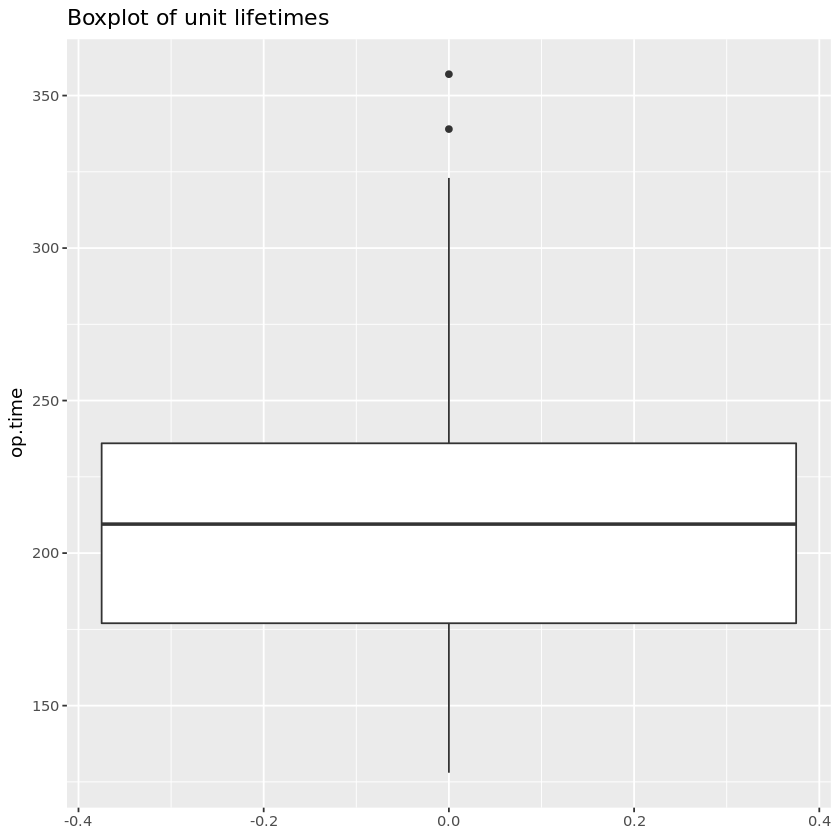

In [8]:
train %>%
  group_by(unit_no) %>%
  mutate(op.time = max(t)) %>%
  ungroup() %>%
  distinct(unit_no, op.time) %>%
  select(op.time) %>%
  mutate(op.time = as.numeric(op.time)) %>%
  ggplot(aes(y = op.time)) +
    geom_boxplot() +
    ggtitle('Boxplot of unit lifetimes')

In [9]:
ttf <- train %>%
  group_by(unit_no) %>%
  arrange(., t, .by_group = T) %>%
  mutate(ttf = -(rev(t) - 1)) %>%
  select(unit_no, ttf)

train$ttf <- ttf$ttf

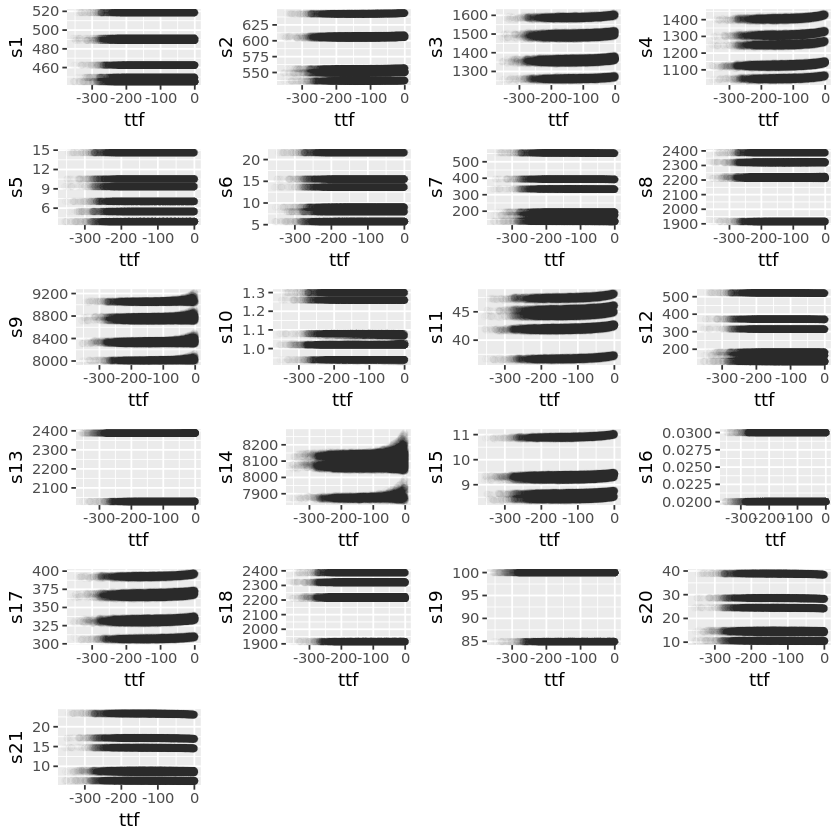

In [10]:
# Isolate the sensor columns
sensor.cols <- colnames(train)[grepl('s\\d', colnames(train))]

# Generate a plot list
plotlist <- lapply(sensor.cols, 
                   function(col){ 
                     train %>%
                       select(col, ttf) %>%
                       ggplot(aes(x = ttf, y = train[, col])) + 
                       geom_point(alpha = 0.01) + ylab(col)
})
  
n <- length(plotlist)
nCol <- floor(sqrt(n))
do.call("grid.arrange", c(plotlist, ncol = nCol))

In [11]:
train %>%
  select(starts_with('s')) %>%
  sapply(., function(x) length(unique(x)))

s1    s2    s3    s4    s5    s6    s7    s8    s9   s10   s11   s12   s13 
    6  1571 11839 14713     6    14  2004   880 20945     8   671  1633   507 
  s14   s15   s16   s17   s18   s19   s20   s21 
14250  8210     2    49     6     2   500 16970

In [12]:
for (col in c('s1', 's5', 's16', 's10', 's16', 's18', 's19'))
{
  print(col)
  print(unique(train[, col]))
}

[1] "s1"
[1] 489.05 518.67 449.44 491.19 445.00 462.54
[1] "s5"
[1] 10.52 14.62  5.48  9.35  3.91  7.05
[1] "s16"
[1] 0.03 0.02
[1] "s10"
[1] 1.26 1.30 1.02 1.08 0.94 1.07 1.03 0.93
[1] "s16"
[1] 0.03 0.02
[1] "s18"
[1] 2319 2388 2223 2324 2212 1915
[1] "s19"
[1] 100.00  84.93


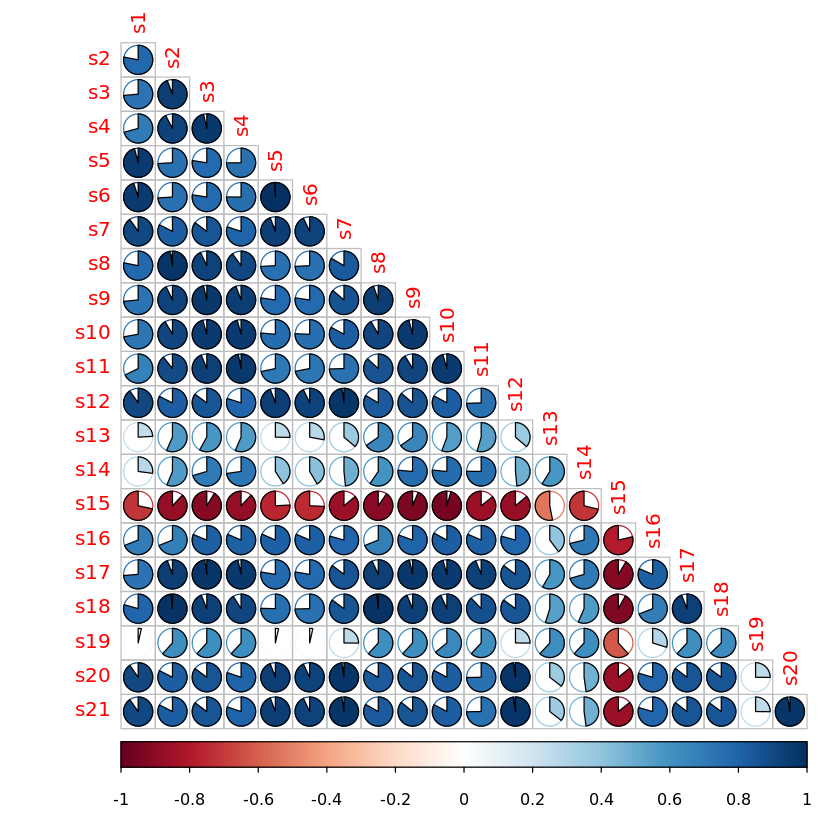

In [13]:
corr.mtrx <- cor(train[, sensor.cols], method = 'spearman')

corrplot(corr.mtrx, method = 'pie', type = 'lower', diag = F)

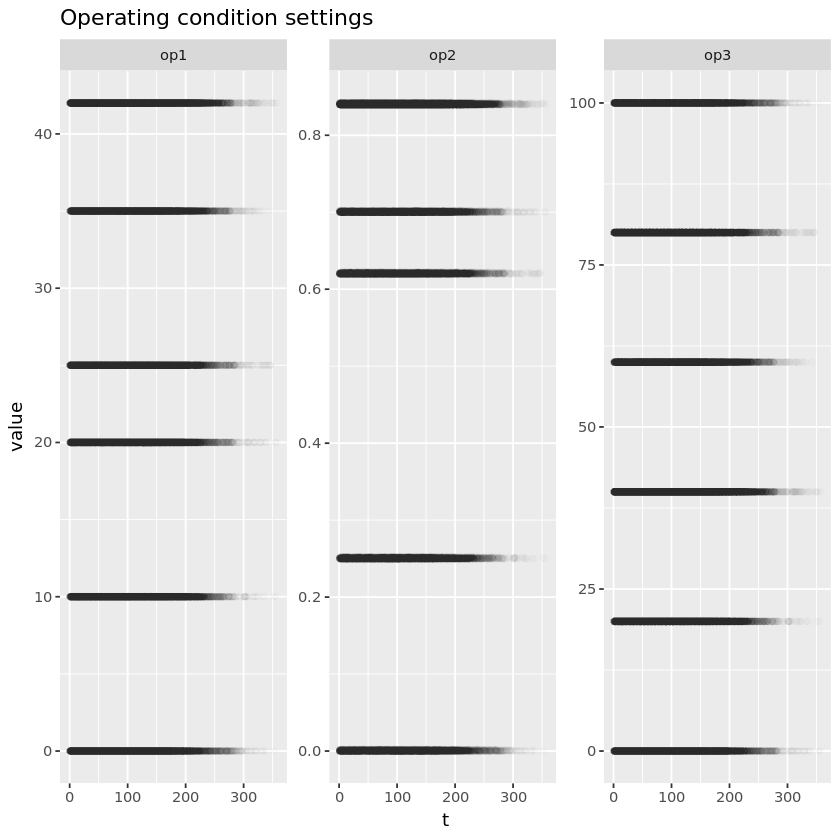

In [14]:
train %>% 
  select(t, op1, op2, op3) %>%
  melt(id = "t") %>%
  ggplot(., aes(x = t, y = value)) +
  geom_point(alpha = 0.0125) +
  facet_wrap(~ variable, scales = "free") +
  ggtitle('Operating condition settings')

In [15]:
#op1
for (setting in c('op1', 'op2', 'op3'))
{
  print(paste('Unique values for', setting, ':', length(unique(train[, setting]))))
}

[1] "Unique values for op1 : 536"
[1] "Unique values for op2 : 105"
[1] "Unique values for op3 : 6"


In [16]:
print(paste('Unique combinations :', dim(unique(train[, c('op1', 'op2', 'op3')]))[1]))

[1] "Unique combinations : 8915"


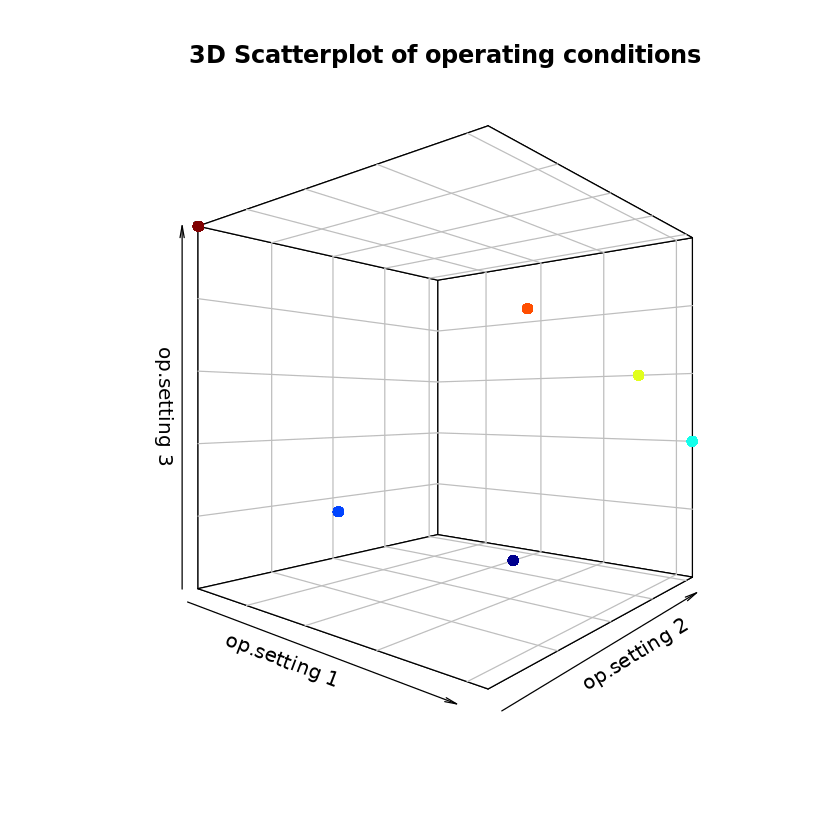

In [17]:
scatter3D(x = train$op1,
          y = train$op2,
          z = train$op3,
          bty = "b2", colkey = F,
          pch = 19, cex = 1,
          theta = 40, phi = 0,
          main = '3D Scatterplot of operating conditions',
          xlab = "op.setting 1",
          ylab ="op.setting 2", 
          zlab = "op.setting 3")

In [18]:
set.seed(1)
op_clusters <- kmeans(train[, c('op1', 'op2', 'op3')], centers = 6, nstart = 48)

op_clusters$centers

op1,op2,op3
35.003053346,0.8404892842,60
42.003043989,0.8405104226,40
25.003012614,0.6205164075,80
0.001516753,0.0004976704,100
10.002962685,0.2505025283,20
20.002946478,0.7004971644,0


In [19]:
# Append cluster no. to the training set
train$op_cluster <- factor(op_clusters$cluster)

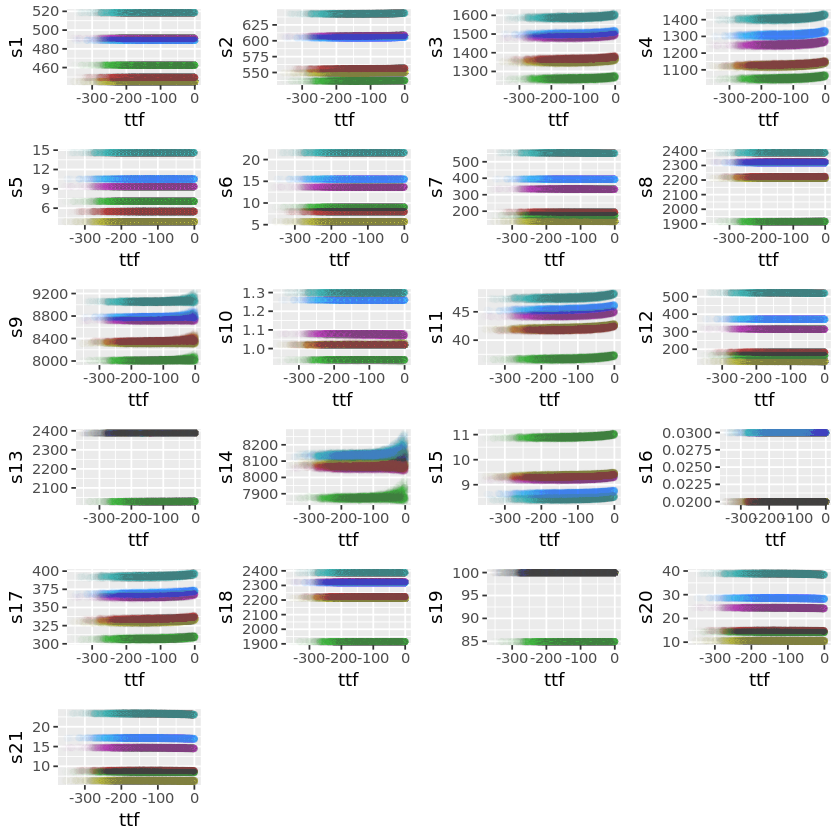

In [20]:
# Generate a plot list
plotlist <- lapply(sensor.cols, 
                   function(col){ 
                     train %>%
                       select(col, ttf, op_cluster) %>%
                       group_by(op_cluster) %>%
                       ggplot(aes(x = ttf, y = train[, col], color = op_cluster)) + 
                       geom_point(alpha = 0.0075) + ylab(col) + 
                       theme(legend.position = 'none')
})
  
n <- length(plotlist)
nCol <- floor(sqrt(n))
do.call("grid.arrange", c(plotlist, ncol = nCol))

In [21]:
# Calculate summary statistics of each sensor per cluster
get_summary_stats <- function(dset)
{
  sensor.cols <- colnames(dset)[grepl("s\\d", colnames(dset))]
  
  sum.stats <- dset %>%
    select(sensor.cols, op_cluster) %>%
    group_by(op_cluster) %>%
    summarize_all(funs(mean, sd))
  return (sum.stats)
}

# Function to standardize the sensors
standardize_sensors <- function(dset, summary_stats)
{
  sensor.cols <- colnames(dset)[grepl("s\\d", colnames(dset))]
  std.sensors <- left_join(dset, summary_stats, by = 'op_cluster')
  std.sensors <- (std.sensors[, sensor.cols] - std.sensors[, paste0(sensor.cols,"_mean")]) / std.sensors[, paste0(sensor.cols,"_sd")]
  return(std.sensors)
}

train.sum.stats <- get_summary_stats(train)
std.sensors <- standardize_sensors(train, train.sum.stats)

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session.”

Warning message:
“Removed 236655 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 236655 rows containing missing values (geom_point).”

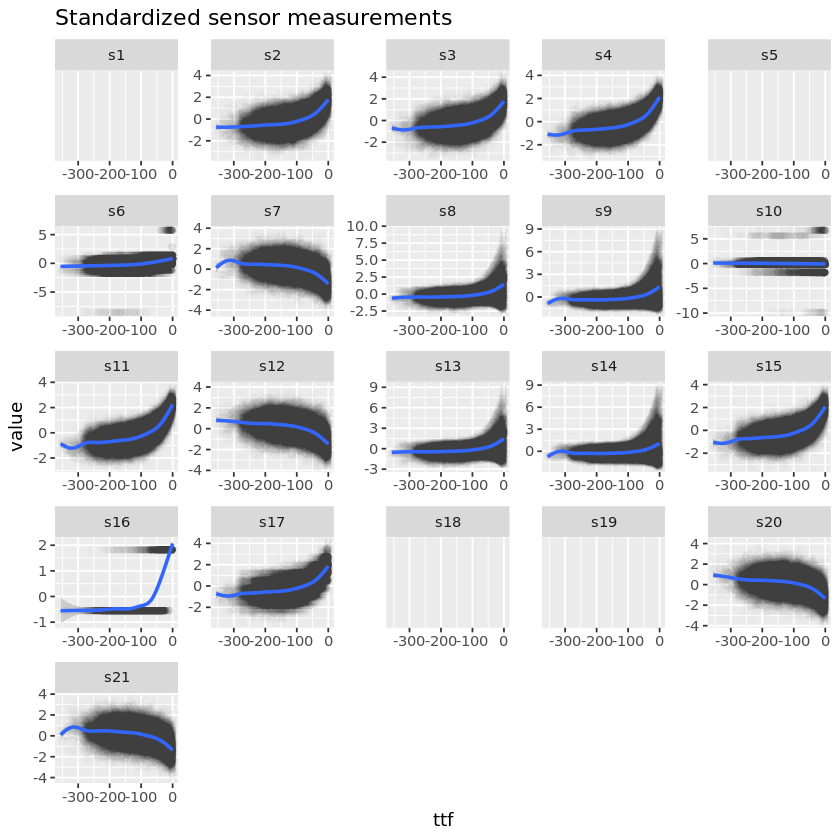

In [22]:
std.sensors %>%
  mutate(ttf = train$ttf) %>%
  melt(id.vars = 'ttf') %>%
  ggplot(aes(x = ttf, y = value)) + 
  geom_point(alpha = 0.0075) + 
  geom_smooth(formula = y ~ s(x, bs = "cs"), 
              method = 'gam') + 
  facet_wrap(~variable, scales = 'free') + 
  ggtitle('Standardized sensor measurements')

In [23]:
missing.data <- sapply(std.sensors, function(x) sum(is.na(x)) / length(x))

missing.data[which(missing.data > 0)]

s1        s5       s10       s16       s18       s19 
1.0000000 1.0000000 0.3013197 0.8525415 1.0000000 1.0000000

No id variables; using all as measure variables


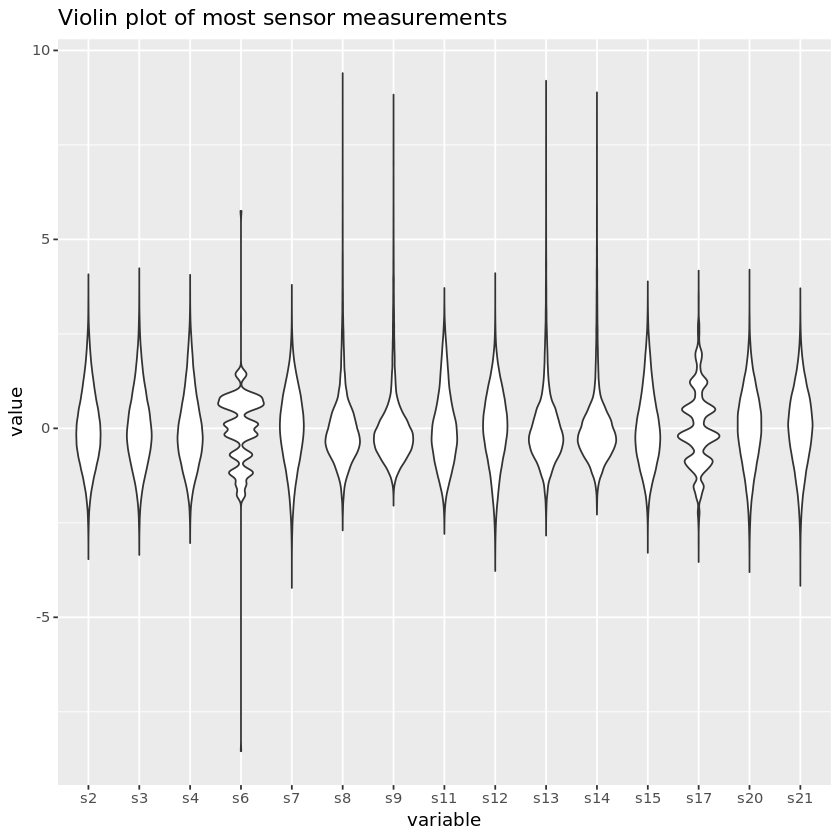

In [24]:
# Append the standardized sensors
train[, sensor.cols] <- std.sensors

sensor.cols.to_drop <- c('s1', 's5', 's10', 's16', 's18', 's19')

# Remove spares
train[, sensor.cols.to_drop] <- NULL

# Make a list with the usable sensors, for later on
usable_sensor.cols <- sensor.cols[!(sensor.cols %in% sensor.cols.to_drop)]


# Append the standardized sensors
train %>%
  select(usable_sensor.cols) %>%
  melt() %>%
  ggplot(aes(y = value)) +
  geom_violin(aes(x = variable))+
  ggtitle('Violin plot of most sensor measurements')

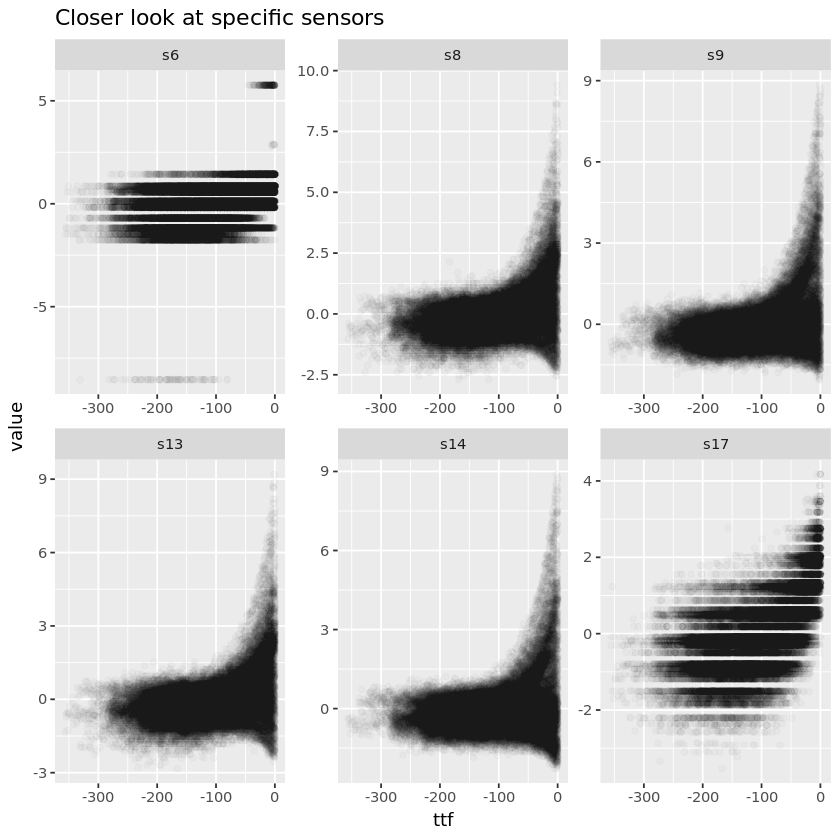

In [25]:
train %>%
  select(ttf, s6, s8, s9, s13, s14, s17) %>%
  melt(id.vars = 'ttf') %>%
  ggplot(aes(x = ttf, y = value)) + 
    geom_point(alpha = 0.02) +
    facet_wrap(~variable, scales = 'free') +
    ggtitle('Closer look at specific sensors')

In [26]:
# Append the standardized sensors
for (sensor in c('s6', 's17'))
{
  no_unique_vals <- length(unique(train[, sensor]))
  print(paste('Unique values', sensor, ':', no_unique_vals))
}

[1] "Unique values s6 : 14"
[1] "Unique values s17 : 64"


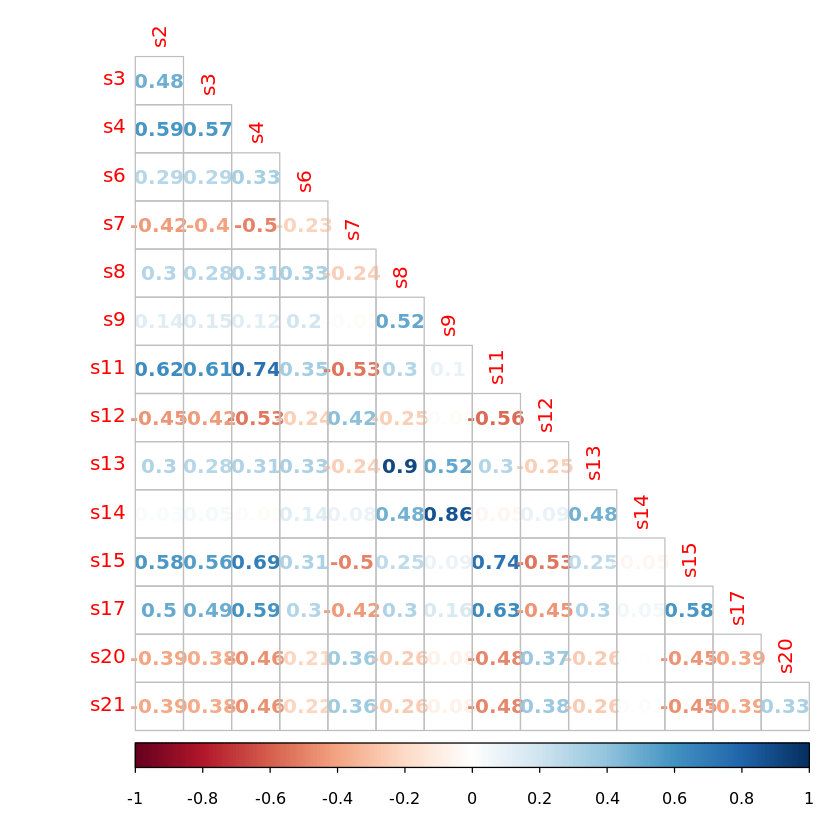

In [27]:
# Plot a correlation matrix
corr.mtrx <- cor(train[, usable_sensor.cols], method = 'spearman')

corrplot(corr.mtrx, method = 'number', type = 'lower', diag = F)

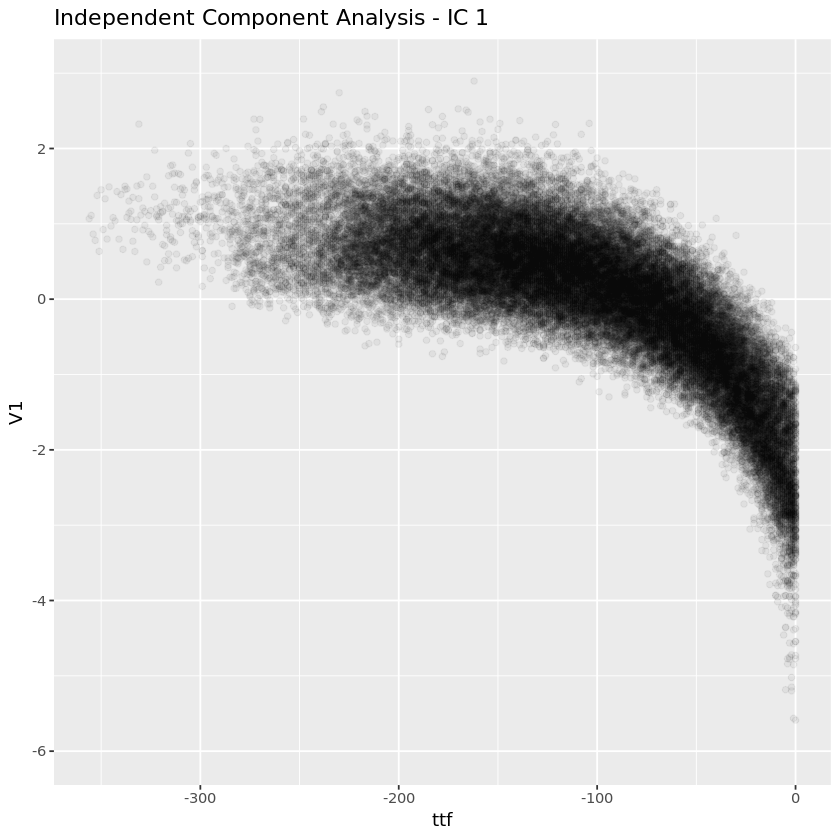

In [28]:
set.seed(1)
ica <- fastICA(train[, usable_sensor.cols], n.comp = 1)

as.data.frame(ica$S) %>% # Grab the source matrix
  mutate(ttf = train$ttf) %>%
  ggplot(aes(x = ttf, y = V1)) + 
    geom_point(alpha = 0.05) +
    ylim(-6, 3) +
    ggtitle("Independent Component Analysis - IC 1")

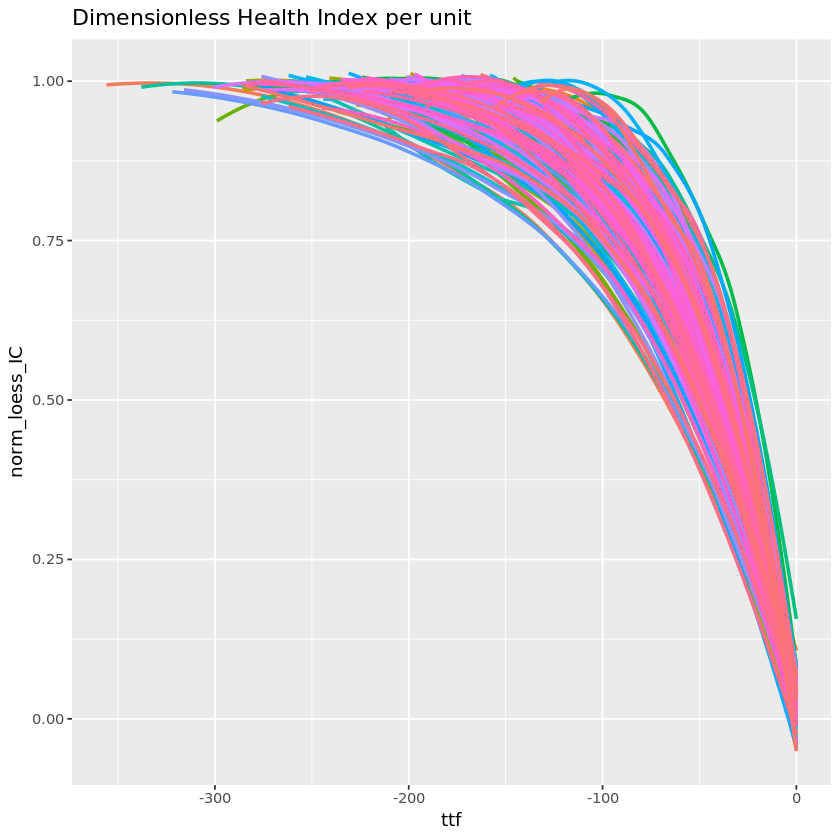

In [29]:
train %>%
  select(ttf, unit_no) %>%
  mutate(IC = as.numeric(ica$S)) %>%
  group_by(unit_no) %>%
  do(loess_IC = predict(loess(IC ~ ttf, span = 0.4, data = .), 
                   data = (.))) %>%
  tidyr::unnest() %>%
  ungroup() %>%
  mutate(ttf = train$ttf) %>%
  mutate(unit_no = train$unit_no) %>%
  group_by(unit_no) %>%
  mutate(norm_loess_IC = (loess_IC - min(loess_IC)) / (max(loess_IC) - min(loess_IC))) %>%
  ungroup() %>%
  ggplot(aes(x = ttf, y = norm_loess_IC, color = unit_no)) + 
    geom_smooth(method = "loess", se = F) + 
    ggtitle('Dimensionless Health Index per unit') + 
    theme(legend.position = "none")


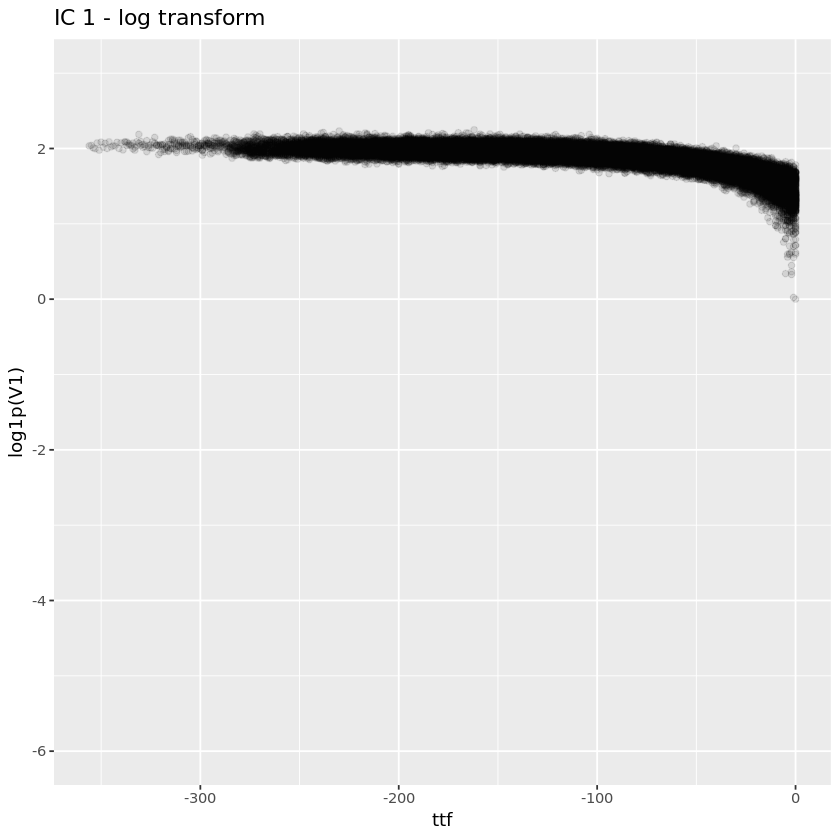

In [30]:
IC.min <- abs(min(as.numeric(ica$S))) # For log transforms

as.data.frame(ica$S + IC.min) %>% # Grab the source matrix
  mutate(ttf = train$ttf) %>%
  ggplot(aes(x = ttf, y = log1p(V1))) + 
    geom_point(alpha = 0.1) +  
    ylim(-6, 3) +
    ggtitle("IC 1 - log transform")

Warning message:
“Removed 979 rows containing non-finite values (stat_boxplot).”

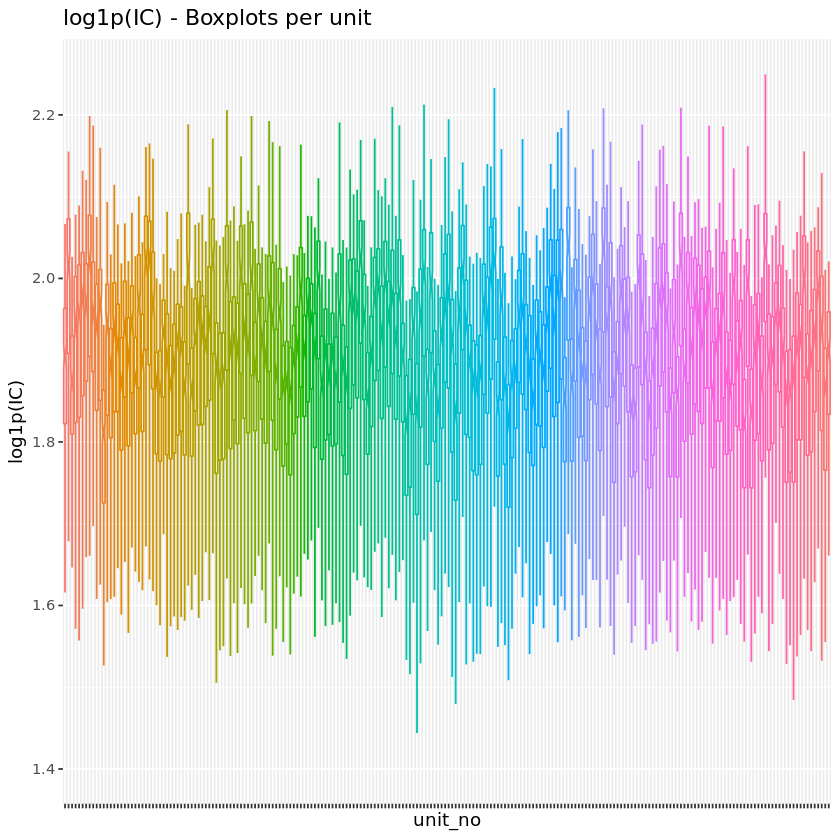

In [31]:
train %>%
  select(ttf, unit_no) %>%
  mutate(IC = ica$S + IC.min) %>%
  group_by(unit_no) %>%
  ggplot(., aes(x = unit_no, y = log1p(IC), color = unit_no)) +
    geom_boxplot(notch = T, outlier.shape = NA) +
    ylim(1.4, 2.25) +
    ggtitle("log1p(IC) - Boxplots per unit") + 
    theme(legend.position = 'none', axis.text.x = element_blank())

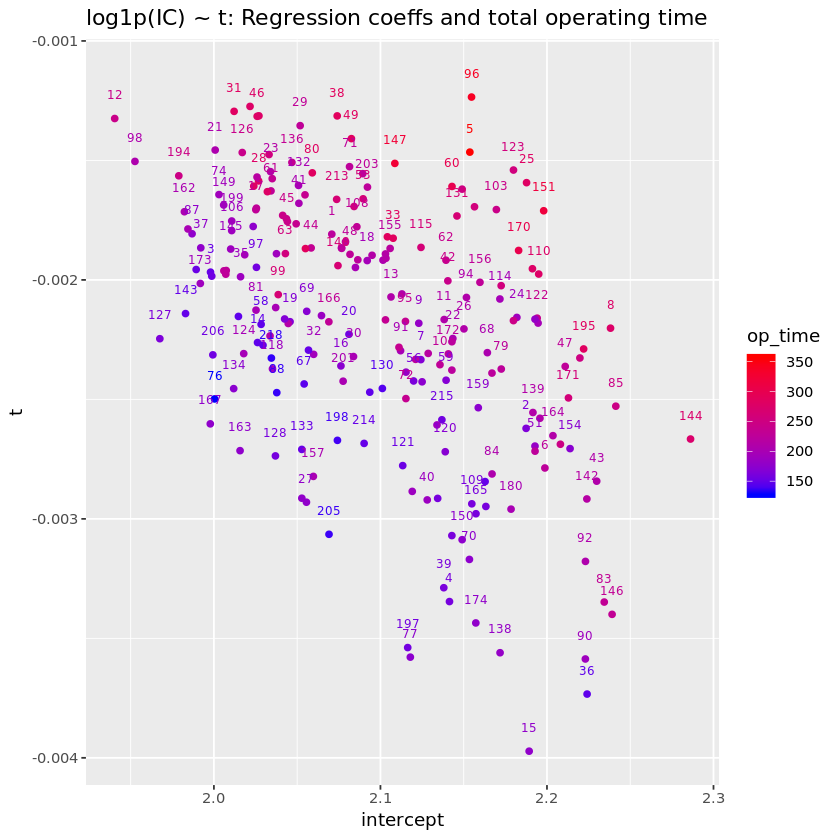

In [32]:
lr.coeffs.train <- train %>%
  select(t, unit_no) %>%
  mutate(IC = log1p(as.numeric(ica$S) + IC.min)) %>%
  group_by(unit_no) %>%
  do(fit_IC = lm(IC ~ t, data = .)) %>%
  tidy(., fit_IC) %>%
  select(unit_no, term, estimate) %>%
  mutate(intercept = ifelse(term == '(Intercept)', estimate, NA)) %>%
  mutate(t = ifelse(term == 't', estimate, NA)) %>%
  mutate(intercept = lag(intercept)) %>%
  select(-term, -estimate) %>%
  na.omit()

op.time <- train %>%
  group_by(unit_no) %>%
  mutate(op.time = max(t)) %>%
  ungroup() %>%
  distinct(unit_no, op.time) %>%
  select(op.time) 

lr.coeffs.train$op_time <- op.time$op.time

ggplot(lr.coeffs.train, aes(x = intercept, y = t, label = unit_no, color = op_time)) + 
  geom_point() + 
  geom_text(size = 2.5, check_overlap = T, nudge_y = 1e-4) +
  ggtitle('log1p(IC) ~ t: Regression coeffs and total operating time') + 
  scale_color_gradient(low="blue", high="red")

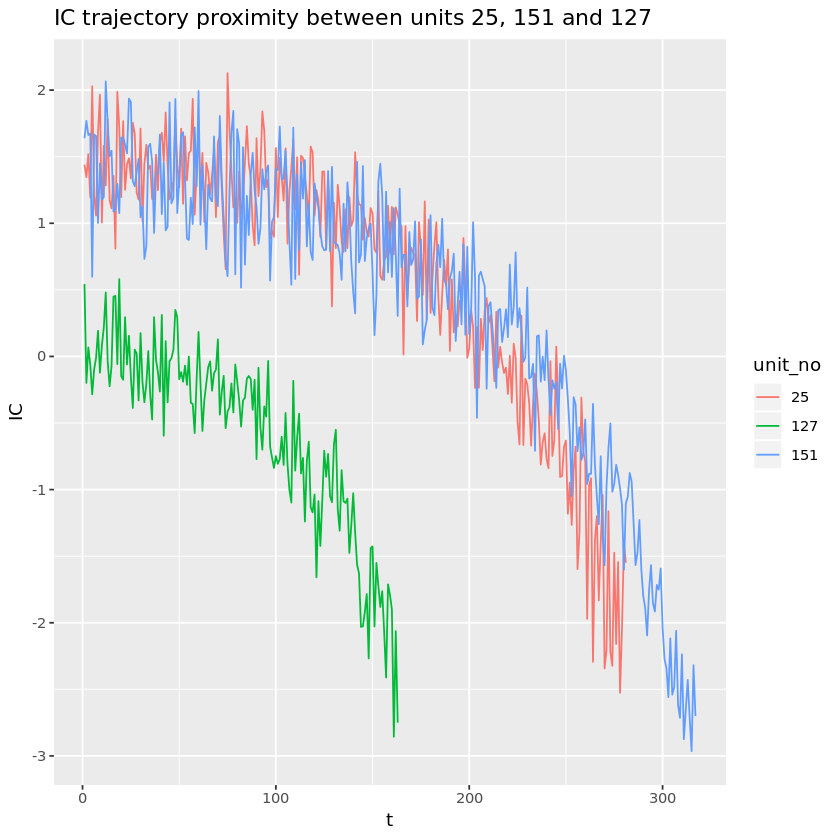

In [33]:
train %>%
  select(t, unit_no) %>%
  mutate(IC = as.numeric(ica$S)) %>%
  filter(unit_no == 25 | unit_no == 151 | unit_no == 127) %>%
  ggplot(aes(x = t, y = IC, color = unit_no)) + 
      geom_line() + 
      ggtitle("IC trajectory proximity between units 25, 151 and 127")

In [34]:
# Function to split the dataset into a train and a validation subset
split_dataset <- function(dset, ratio)
{
  # Get the total number of units present in the dataset
  total_units <- max(as.numeric(dset$unit_no))
  
  # Randomly select a number of units
  val_units <- sample(1:total_units, size = round(total_units * ratio))
  
  # Get the indices from the dataset that belong to these units
  val_indices <- which(dset$unit_no %in% val_units)
  
  # Split into new datasets
  val <- dset[val_indices, ]
  train <- dset[-val_indices, ]
  
  return(list(train, val))
}

In [35]:
# Function to return the operating cluster
get_cluster <- function(dset, centers)
{
  # Isolate the operating settings
  clusters <- dset %>%
  select(op1, op2, op3) 

  # Calculate Euclidean distance between each operating setting and all cluster centers
  clusters <- as.data.frame(t(apply(clusters, 1, 
                                    function(y) apply(centers, 1, 
                                                      function(x) sum(sqrt((y - x) ^2)) )))) %>%
    mutate(op_cluster = apply(., 1, function(x){names(x)[which.min(x)]})) %>%
    mutate(op_cluster = as.numeric(op_cluster)) %>% # Convert from list
    select(op_cluster)
  
  # Return
  return(clusters)
}

In [36]:
# Function to apply whitening
get_IC <- function(input_df, ica_obj)
{
  # Multiply each row of the dataset with the whitening matrix.
  ic <- as.matrix(input_df) %*% ica_obj$K
  # Return it
  return(ic)
}

In [37]:
# Function to get the regression coefficients
get_coeffs <- function(dset, ica_obj)
{
  IC.min <- min(as.numeric(ica_obj$S)) # For the log transform
  
  lr.coeffs <- dset %>%
    select(t, unit_no, IC) %>%
    filter(IC > IC.min) %>%
    mutate(IC = log1p(as.numeric(IC) + abs(IC.min))) %>% 
    group_by(unit_no) %>%
    do(fit_IC = lm(IC ~ t, data = .)) %>%
    tidy(., fit_IC) %>%
    select(unit_no, term, estimate) %>%
    mutate(intercept = ifelse(term == '(Intercept)', estimate, NA)) %>%
    mutate(t = ifelse(term == 't', estimate, NA)) %>%
    mutate(intercept = lag(intercept)) %>%
    select(-term, -estimate) %>%
    na.omit() %>%
    ungroup()
  
  return(lr.coeffs)
}

In [38]:
# Function to standardize the coefficients of the LR model
std_coeffs <- function(input.coeffs, train.coeffs)
{
  # Get summary stats
  mean.t <- mean(train.coeffs$t)
  sd.t <- sd(train.coeffs$t)
  mean.int <- mean(train.coeffs$intercept)
  sd.int <- sd(train.coeffs$intercept)
  
  # Normalize them
  input.coeffs <- input.coeffs %>%
    mutate(t = (t - mean.t) / sd.t) %>%
    mutate(intercept = (intercept - mean.int) / sd.int)
  
  return(input.coeffs)
}

In [39]:
# Function to calculate the error metric
get_metric <- function(model.predictions, true.values)  
{
  d <- model.predictions - true.values
  d <- ifelse(d <= 0, exp(-d / 13) - 1, exp(d / 10) - 1)
  return(mean(d))
}

In [40]:
# Function to cut down the validation data below a certain time threshold
cut_dset <- function(dset, cutoff)
{
  partial <- dset %>%
    group_by(unit_no) %>%
    filter(t < max(t) * cutoff) %>%
    ungroup()
  
  return(partial)
}

# Function to return the total operating time for each unit in a dataset
get_total_time <- function(dset)
{
  dset.new <- dset %>%
  group_by(unit_no) %>%
  mutate(op.time = max(t)) %>%
  ungroup() %>%
  distinct(unit_no, op.time) %>%
  select(unit_no, op.time) %>%
  mutate(op.time = as.numeric(op.time))
  
  return(dset.new)
}

# Function to determine the mode of a given set of data
get_mode <- function(x) {
  # Estimate the probability mass function distribution, given the data
  dx <- density(x, na.rm = T)
  # Get the value that maximizes the probability mass function
  mode <- dx$x[which.max(dx$y)]
  return(mode) 
} 

In [41]:
# Function to preprocess the training set
preprocess_original_dset <- function(dset)
{
  
  # Train a k-means algorithm to estimate the operating clusters
  op_clusters <- kmeans(dset[, c('op1', 'op2', 'op3')], 
                        centers = 6, 
                        nstart = 48)
  
  # Append the clusters on the set
  dset[, 'op_cluster'] <- op_clusters$cluster
    
  # Drop redundant sensors
  dset[, c('s1', 's5', 's10', 's16', 's18', 's19')] <- NULL
  
  # Calculate summary statistics for each sensor per cluster on the training set
  dset.sum.stats <- get_summary_stats(dset)
  
  # Standardize the sensors
  usable_sensor.cols <- colnames(dset)[grepl('s\\d', colnames(dset))]
  dset[, usable_sensor.cols] <- standardize_sensors(dset, dset.sum.stats)
  
  # Apply ICA on the data set
  ica <- fastICA(dset[, usable_sensor.cols], n.comp = 1)
  
  # Get the independent component
  dset$IC <- as.numeric(get_IC(dset[, usable_sensor.cols], ica))
  
  # Extract the linear regression coefficients
  lr.coeffs <- get_coeffs(dset, ica) 
  
  # Return list with outputs
  out <- list("train_summary_statistics" = dset.sum.stats,
              "op_settings_clustering" = op_clusters,
              "ICA_object" = ica,
              "LR_coeffs" = lr.coeffs)
  
  return(out)
}

# Function to preprocess the validation set (up to the point which is common for the two models)
preprocess_synthetic <- function(dset, params, for_test_set)
{
  if (for_test_set == F)
  {
    # Get total operating time
    y <- dset %>%
      distinct(unit_no, op.time) %>%
      select(op.time)
  }
  
  # Get operating cluster
  clusters <- get_cluster(dset, params$op_settings_clustering$centers)
  dset <- cbind(dset, clusters)
    
  # Drop redundant sensors
  dset[, c('s1', 's5', 's10', 's16', 's18', 's19')] <- NULL
  
  # Standardize the sensors
  usable_sensor.cols <- colnames(dset)[grepl('s\\d', colnames(dset))]
  dset[, usable_sensor.cols] <- standardize_sensors(dset, params$train_summary_statistics)
  
  # Get the independent component
  dset$IC <- as.numeric(get_IC(dset[, usable_sensor.cols], params$ICA_object))
  
  # Get the linear coefficients from the ICA object
  lr.coeffs <- get_coeffs(dset, params$ICA_object) 
  
  # Generate the new dataset
  if (for_test_set == F)
  {
    new_dset <- as.data.frame(std_coeffs(lr.coeffs, params$LR_coeffs)) %>%
      mutate(target = y$op.time) %>%
      select(-unit_no)
  } else {
    new_dset <- as.data.frame(std_coeffs(lr.coeffs, params$LR_coeffs)) %>%
      select(-unit_no)
  }
  
  return(new_dset)
}

In [42]:
# Reproducibility
set.seed(1)

val_ratio <- 0.3 # 30% of the data will go to the validation set

# Clean read
data <- data.frame(read_data(url("https://raw.githubusercontent.com/gomathyshankar/PrognosticsData/master/Challenge_Data/train.txt")))

# Split into three datasets
data <- split_dataset(data, val_ratio) # Remove the holdout set
train <- data[[1]]
val <- data[[2]]

# Get the objects needed for preprocessing the new datasets
preprocess_objects <- train %>% preprocess_original_dset

# Truncation limits and number of datasets to generate
no.datasets <- 80
min.lifetime <- 0.2
max.lifetime <- 0.9

# Generate the new datasets
new.train <- lapply(seq_len(no.datasets), function(x){
                                  train %>% 
                                  group_by(unit_no) %>%
                                  mutate(op.time = max(t)) %>%
                                  filter(t <= round(max(t) * sample(seq(min.lifetime, 
                                                                        max.lifetime,
                                                                        by = 0.05), 
                                                                    size = 1))) %>%
                                  ungroup %>% 
                                  do(preprocess_synthetic(., preprocess_objects, F))}) %>%
  do.call("rbind", .)

In [45]:
# Reproducibility
set.seed(1)
  
# Re-write this to the proper format for Caret
eval_metric <- function(data, lev = NULL, model = NULL) { # Compute the competition metric
                        y_hat = data$pred
                        y = data$obs
                        d <- y_hat - y
                        d <- ifelse(d <= 0, exp(-d / 13) - 1, exp(d / 10) - 1)
                        score_val <- mean(d)
                        c(S = score_val)
                        }

# Generate the models
model_list <- caretList(
  target ~ ., 
  data = new.train,
  metric = "S",
  maximize = F, 
  trControl = trainControl(
    method = "repeatedcv", # Don't know how stable each model will be
    number = 20,
    repeats = 10,
    savePredictions = "final",
    summaryFunction = eval_metric,
    index = createResample(new.train$target, 20)
    ),
  methodList = c("lm", "rpart", "svmRadial", "cubist", "rf"),
  tuneList = list(gbm = caretModelSpec(method = "gbm", verbose = F))
  )

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



In [ ]:
# collect resamples
results <- resamples(model_list)

# Show results
bwplot(results)

In [ ]:
# Prediction correlations
corrplot(modelCor(results), method = "number", diag = F, type = "lower")

In [ ]:
# Reproductibility
set.seed(1)

# Create the ensemble
greedy_ensemble <- caretEnsemble(
  all.models = model_list, 
  metric = "S",
  maximize = F,
  trControl = trainControl(
    savePredictions = "none",
    method = "repeatedcv",
    summaryFunction = eval_metric,
    number = 10,
    repeats = 5)
  )

# Show results
autoplot(greedy_ensemble)

In [ ]:
# Reproducibility
set.seed(1)

# Make the model
gbm_ensemble <- caretStack(
  all.models = model_list,
  method = "gbm",
  metric = "S",
  maximize = F, 
  verbose = F,
  trControl = trainControl(
    method = "repeatedcv",
    summaryFunction = eval_metric,
    number = 20,
    repeats = 5,
    savePredictions = "none")
)

# Show results
print(gbm_ensemble)

In [ ]:
# Reproducibility
set.seed(1)

# Tuning grid
xgb_grid <- expand.grid(nrounds = 50,
                        max_depth = 2,
                        eta = 0.11,
                        gamma = 1,
                        min_child_weight = 1,
                        subsample = 1,
                        colsample_bytree = 0.95)

# Train control for Caret
xgb_Control <- trainControl(method = "repeatedcv", 
                            number = 10, 
                            repeats = 5, 
                            verboseIter = F,
                            summaryFunction = eval_metric,
                            savePredictions = "none",
                            allowParallel = F)

# Make the dataset from the base models
xgb_dset <- data.frame(lapply(model_list, function(model) model$pred$pred) %>% do.call("cbind", .))

# And append the target
xgb_dset$target <- model_list[[1]]$pred$obs

# Train
xgb <- train(target~., 
             data = xgb_dset,
             method = "xgbTree",
             metric = "S",
             maximize = F,
             trControl = xgb_Control,
             tuneGrid = xgb_grid)

# Show results
print(xgb)

In [46]:
set.seed(1)

new.val <- val %>%
  group_by(unit_no) %>%
  mutate(op.time = max(t)) %>%
  filter(t <= round(max(t) * sample(seq(min.lifetime,
                                        max.lifetime,
                                        by = 0.2), 
                                    size = 1))) %>%
  ungroup %>% 
  do(preprocess_synthetic(., preprocess_objects, F))

model <- c("gbm", "rpart", "weight_avg.ensemble", "gbm_ensemble", "xgb_ensemble")
dset <- rep(c("train", "val"), length(model))
results <- list(mean(model_list$gbm$results$S),
                predict(model_list$gbm, newdata = new.val) %>%
                  get_metric(., new.val$target),
                mean(model_list$rpart$results$S),
                predict(model_list$rpart, newdata = new.val) %>%
                  get_metric(., new.val$target),
                mean(greedy_ensemble$error$S),
                predict(greedy_ensemble, newdata = new.val) %>%
                  get_metric(., new.val$target),
                mean(gbm_ensemble$error$S),
                predict(gbm_ensemble, newdata = new.val) %>%
                  get_metric(., new.val$target),
                mean(xgb$results$S),
                predict(model_list, new.val) %>%
                  predict(xgb, .) %>%
                  get_metric(., new.val$target))

results <- data.frame("model" = unlist(rep(model, each = 2)),
                      "dset" = unlist(rep(c("train", "val"), length(model))),
                      "err.metric" = unlist(results))

ggplot(results, aes(x = model, y = log(err.metric), fill = dset)) + 
  geom_bar(stat="identity", position=position_dodge()) + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ERROR: Error in mean(greedy_ensemble$error$S): object 'greedy_ensemble' not found


In [ ]:
prediction_set <- data.frame(read_data('test.txt'))

running.cycles <- get_total_time(prediction_set) %>% select(op.time)

total.cycles <-  prediction_set %>%
  do(preprocess_synthetic(., preprocess_objects, T)) %>%
  predict(model_list, .) %>%
  predict(xgb, .) %>%
  round(.) 

total.cycles - running.cycles %>%
  mutate(op.time = ifelse(op.time < 0, 0, op.time)) %>% # In case we predict negative values
  write.table(., file = "predictions.txt", sep = "", row.names = F, col.names = F)